In [120]:
# Sentinel-1 Data

This notebook aims to test some Data Cube functions using Sentinel-1 data

First... we do all the necessary imports !

SyntaxError: invalid syntax (<ipython-input-120-48cae939bc0f>, line 3)

In [1]:
%matplotlib inline
# necessary for plot display in jupyter

from datetime import date
import json
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import numpy
import time
from datacube.api.model import DatasetType, Satellite, BANDS, PercentileMoistureBands, \
    PercentilePrecipitationBands,PrecipitableWaterForecastBands
from datacube.api.query import list_tiles_as_list
from datacube.api.utils import get_dataset_data, get_dataset_metadata
from eotools.tiling import generate_tiles
from eotools.coordinates import convert_coordinates
from idl_functions import histogram
from math import log10
from scipy import optimize
from scipy import interpolate
from scipy import signal

In [2]:
import sys

def my_print(text):
    sys.stdout.write(str(text))
    sys.stdout.flush()

#### We define all the parameters we want to retrieve the data

In [123]:
dataset_types = [DatasetType.MOISTURE_PERCENTILE]
min_date = date(2000, 01, 01)
max_date = date(2000, 02, 01)
satellites = [Satellite(i) for i in ['Percentile']]
x_cell = [0]
y_cell = [4]

#### We request the tiles according to the parameters and we check that we have the 6 tiles corresponding to our Landsat image

In [124]:
tiles = list_tiles_as_list(x=x_cell, y=y_cell, acq_min=min_date,
                           acq_max=max_date,
                           satellites=satellites,
                           dataset_types=dataset_types)

In [125]:
print "Number of tiles: {}".format(len(tiles))

Number of tiles: 1


#### Method to get data from a tile

In [126]:
def getDatasetFromTile(tile, datasetType):
    dataset = tile.datasets[datasetType]
    data = get_dataset_data(dataset)
    metadata = get_dataset_metadata(dataset)
    samples, lines = metadata.shape
    #print "Tile file path location: {path}".format(path=dataset.path)
    #print "Array dimensions:\nx: {x} & y: {y}".format(x=samples, y=lines)
    return data

In [127]:
def second_smallest(numbers):
    m1, m2 = float('inf'), float('inf')
    for sub in numbers:
        for x in sub:
            if x < m1:
                m1, m2 = x, m1
            elif x < m2 and x != m1:
                m2 = x
    return m2

In [128]:
def clearNan(bandData, replaceValue=-32768):
    nanLocations = np.isnan(bandData)
    bandData[nanLocations] = replaceValue
    return bandData

#### Method to display a tile. If a threshold is given as parameter, a mask is applied.

In [129]:
def showDataset(data, band, threshold=None, vmin=0, vmax=1):
    bandData = clearNan(data.get(band))
    matrix = np.reshape(bandData, (-1, 40))
    plt.figure()
    if (threshold == None):
        plt.imshow(matrix, cmap = cm.Greys_r, vmin=vmin, vmax=vmax)
    else:
        thresh = (matrix[:, :] > 0) & (matrix[:, :] < threshold)
        plt.imshow(thresh, cmap=cm.gray)
    plt.colorbar()
    plt.show()
    plt.close()

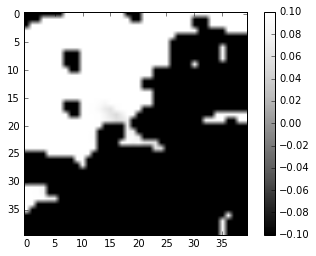

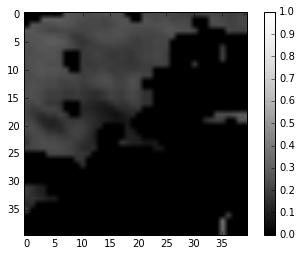

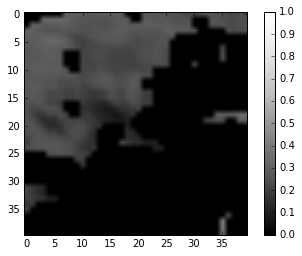

In [117]:
data = getDatasetFromTile(tiles[0], DatasetType.MOISTURE_PERCENTILE)
showDataset(data, PercentileMoistureBands._65, vmin=second_smallest(data.get(PercentileMoistureBands._65)),
           vmax=data.get(PercentileMoistureBands._65).max())
showDataset(data, PercentileMoistureBands._85)
showDataset(data, PercentileMoistureBands._95)

In [115]:
print "Min 65", second_smallest(data.get(PercentileMoistureBands._65))
print "Max 65", data.get(PercentileMoistureBands._65).max()
print "Min 85", second_smallest(data.get(PercentileMoistureBands._85))
print "Max 85", data.get(PercentileMoistureBands._85).max()
print "Min 95", second_smallest(data.get(PercentileMoistureBands._95))
print "Max 95", data.get(PercentileMoistureBands._95).max()

Min 65 0.0515693500638
Max 65 0.329562664032
Min 85 0.0621992498636
Max 85 0.371494472027
Min 95 0.0778961181641
Max 95 0.425534695387


Number of tiles: 1


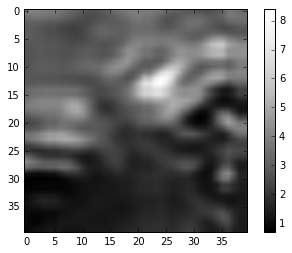

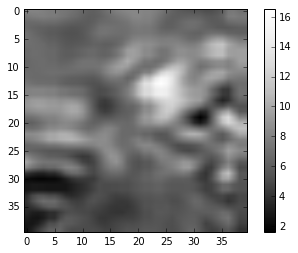

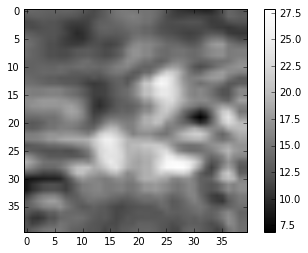

In [98]:
dataset_types = [DatasetType.PRECIPITATION_PERCENTILE]
tiles = list_tiles_as_list(x=x_cell, y=y_cell, acq_min=min_date,
                           acq_max=max_date,
                           satellites=satellites,
                           dataset_types=dataset_types)
print "Number of tiles: {}".format(len(tiles))
data = getDatasetFromTile(tiles[0], DatasetType.PRECIPITATION_PERCENTILE)
showDataset(data, PercentilePrecipitationBands._85, vmin=data.get(PercentilePrecipitationBands._85).min(), 
            vmax=data.get(PercentilePrecipitationBands._85).max())
showDataset(data, PercentilePrecipitationBands._95, vmin=data.get(PercentilePrecipitationBands._95).min(), 
            vmax=data.get(PercentilePrecipitationBands._95).max())
showDataset(data, PercentilePrecipitationBands._99, vmin=data.get(PercentilePrecipitationBands._99).min(), 
            vmax=data.get(PercentilePrecipitationBands._99).max())

In [99]:
print "Min 85", data.get(PercentilePrecipitationBands._85).min()
print "Max 85", data.get(PercentilePrecipitationBands._85).max()
print "Min 95", data.get(PercentilePrecipitationBands._95).min()
print "Max 95", data.get(PercentilePrecipitationBands._95).max()
print "Min 99", data.get(PercentilePrecipitationBands._99).min()
print "Max 99", data.get(PercentilePrecipitationBands._99).max()

Min 85 0.691217005253
Max 85 8.41627788544
Min 95 1.5929671526
Max 95 16.5513458252
Min 99 6.88850498199
Max 99 27.8963375092


Number of tiles: 1


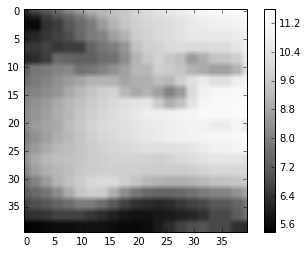

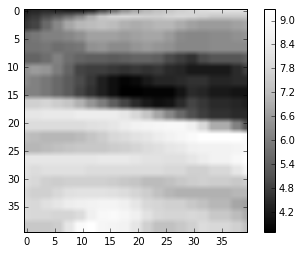

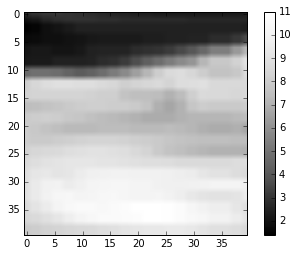

In [100]:
dataset_types = [DatasetType.PRECIPITABLE_WATER_FORECAST]
min_date = date(2016, 01, 01)
max_date = date(2016, 02, 01)
satellites = [Satellite(i) for i in ['Forecast']]
tiles = list_tiles_as_list(x=x_cell, y=y_cell, acq_min=min_date,
                           acq_max=max_date,
                           satellites=satellites,
                           dataset_types=dataset_types)
print "Number of tiles: {}".format(len(tiles))
data = getDatasetFromTile(tiles[0], DatasetType.PRECIPITABLE_WATER_FORECAST)
showDataset(data, PrecipitableWaterForecastBands._1, vmin=data.get(PrecipitableWaterForecastBands._1).min(), 
            vmax=data.get(PrecipitableWaterForecastBands._1).max())

showDataset(data, PrecipitableWaterForecastBands._3, vmin=data.get(PrecipitableWaterForecastBands._3).min(), 
            vmax=data.get(PrecipitableWaterForecastBands._3).max())

showDataset(data, PrecipitableWaterForecastBands._5, vmin=data.get(PrecipitableWaterForecastBands._5).min(), 
            vmax=data.get(PrecipitableWaterForecastBands._5).max())

In [101]:
print "Min 1", data.get(PrecipitableWaterForecastBands._1).min()
print "Max 1", data.get(PrecipitableWaterForecastBands._1).max()
print "Min 3", data.get(PrecipitableWaterForecastBands._3).min()
print "Max 3", data.get(PrecipitableWaterForecastBands._3).max()
print "Min 5", data.get(PrecipitableWaterForecastBands._5).min()
print "Max 5", data.get(PrecipitableWaterForecastBands._5).max()

Min 1 5.4
Max 1 11.6
Min 3 3.7
Max 3 9.3
Min 5 1.4
Max 5 11.0
